In this notebook, you will implement the kinematic bicycle model. The model accepts velocity and steering rate inputs and steps through the bicycle kinematic equations. Once the model is implemented, you will provide a set of inputs to drive the bicycle in a figure 8 trajectory.

The bicycle kinematics are governed by the following set of equations:

\begin{align*}
\dot{x}_c &= v \cos{(\theta + \beta)} \\
\dot{y}_c &= v \sin{(\theta + \beta)} \\
\dot{\theta} &= \frac{v \cos{\beta} \tan{\delta}}{L} \\
\dot{\delta} &= \omega \\
\beta &= \tan^{-1}(\frac{l_r \tan{\delta}}{L})
\end{align*}

where the inputs are the bicycle speed $v$ and steering angle rate $\omega$. The input can also directly be the steering angle $\delta$ rather than its rate in the simplified case. The Python model will allow us both implementations.

In order to create this model, it's a good idea to make use of Python class objects. This allows us to store the state variables as well as make functions for implementing the bicycle kinematics. 

The bicycle begins with zero initial conditions, has a maximum turning rate of 1.22 rad/s, a wheelbase length of 2m, and a length of 1.2m to its center of mass from the rear axle.

From these conditions, we initialize the Python class as follows:

In [75]:
from notebook_grader import BicycleSolution, grade_bicycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Bicycle():
    def __init__(self):
        self.xc = 0
        self.yc = 0
        self.theta = 0
        self.delta = 0
        self.beta = 0
        
        self.L = 2
        self.lr = 1.2
        self.w_max = 1.22
        
        self.sample_time = 0.01
        
    def reset(self):
        self.xc = 0
        self.yc = 0
        self.theta = 0
        self.delta = 0
        self.beta = 0

A sample time is required for numerical integration when propagating the kinematics through time. This is set to 10 milliseconds. We also have a reset function which sets all the state variables back to 0. 

With this sample time, implement the kinematic model using the function $\textit{step}$ defined in the next cell. The function should take speed + angular rate as inputs and update the state variables. Don't forget about the maximum turn rate on the bicycle!

In [76]:
class Bicycle(Bicycle):
    def step_e(self, v, w):
        # ==================================
        #  Implement kinematic model here
        # ==================================
        dt = self.sample_time
        w = np.clip(w, -self.w_max, self.w_max)
        self.delta += w * dt
        self.beta = np.arctan(self.lr * np.tan(self.delta) / self.L)
        self.xc += v * np.cos(self.theta + self.beta) * dt
        self.yc += v * np.sin(self.theta + self.beta) * dt
        self.theta += v * np.cos(self.beta) * np.tan(self.delta) / self.L * dt
        
    def step_RK4(self, v, w):
        # ==================================
        #  Implement kinematic model here
        # ==================================
        dt = self.sample_time
        w = np.clip(w, -self.w_max, self.w_max)
        
        def dynamic(state, delta):
            theta, xc, yc = state
            beta = np.arctan(self.lr * np.tan(delta) / self.L)
            dx = v * np.cos(theta + beta)
            dy = v * np.sin(theta + beta)
            dtheta = v * np.cos(beta) * np.tan(delta) / self.L
            return np.array([dtheta, dx, dy])
        
        state = np.array([self.theta, self.xc, self.yc])
        delta1 = self.delta
        delta2 = self.delta + 0.5 * dt * w
        delta3 = self.delta + 0.5 * dt * w
        delta4 = self.delta + dt * w
        
        k1 = dynamic(state, delta1)
        k2 = dynamic(state + 0.5 * dt * k1, delta2)
        k3 = dynamic(state + 0.5 * dt * k2, delta3)
        k4 = dynamic(state + dt * k3, delta4)
        
        state_new = state + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        self.theta, self.xc, self.yc = state_new
        self.delta += w * dt
        self.beta = np.arctan((self.lr / self.L) * np.tan(self.delta))

With the model setup, we can now start giving bicycle inputs and producing trajectories. 

Suppose we want the model to travel a circle of radius 10 m in 20 seconds. Using the relationship between the radius of curvature and the steering angle, the desired steering angle can be computed.

\begin{align*}
    \tan{\delta} &= \frac{L}{r} \\
    \delta &= \tan^{-1}(\frac{L}{r}) \\
           &= \tan^{-1}(\frac{2}{10}) \\
           &= 0.1974
\end{align*}

If the steering angle is directly set to 0.1974 using a simplied bicycled model, then the bicycle will travel in a circle without requiring any additional steering input. 

The desired speed can be computed from the circumference of the circle:

\begin{align*}
    v &= \frac{d}{t}\\
     &= \frac{2 \pi 10}{20}\\
     &= \pi
\end{align*}

We can now implement this in a loop to step through the model equations. We will also run our bicycle model solution along with your model to show you the expected trajectory. This will help you verify the correctness of your model.

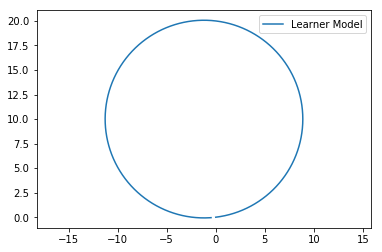

In [77]:
sample_time = 0.01
time_end = 20
model = Bicycle()
solution_model = BicycleSolution()

# set delta directly
model.delta = np.arctan(2/10)
solution_model.delta = np.arctan(2/10)

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    model.step_RK4(np.pi, 0)
    
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc
    solution_model.step(np.pi, 0)
    
    #model.beta = 0
    #solution_model.beta=0
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.legend()
plt.show()

The plot above shows the desired circle of 10m radius. The path is slightly offset which is caused by the sideslip effects due to $\beta$. By forcing $\beta = 0$ through uncommenting the last line in the loop, you can see that the offset disappears and the circle becomes centered at (0,10). 

However, in practice the steering angle cannot be directly set and must be changed through angular rate inputs $\omega$. The cell below corrects for this and sets angular rate inputs to generate the same circle trajectory. The speed $v$ is still maintained at $\pi$ m/s.

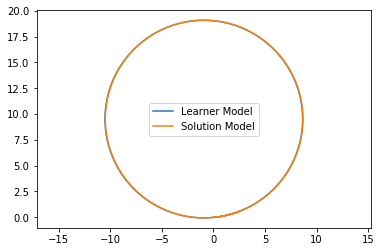

In [78]:
sample_time = 0.01
time_end = 20
model.reset()
solution_model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)

for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    
    if model.delta < np.arctan(2/10):
        model.step_RK4(np.pi, model.w_max)
    else:
        model.step_RK4(np.pi, 0)
        
    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc
    
    if solution_model.delta < np.arctan(2/10):
        solution_model.step(np.pi, model.w_max)
    else:
        solution_model.step(np.pi, 0)    

plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.plot(x_solution, y_solution,label='Solution Model')
plt.legend()
plt.show()

Here are some other example trajectories: a square path, a spiral path, and a wave path. Uncomment each section to view.

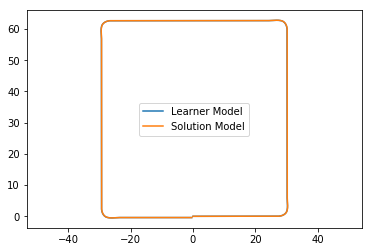

In [80]:
sample_time = 0.01
time_end = 60
model.reset()
solution_model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
x_solution = np.zeros_like(t_data)
y_solution = np.zeros_like(t_data)

# maintain velocity at 4 m/s
v_data = np.zeros_like(t_data)
v_data[:] = 4 

w_data = np.zeros_like(t_data)

# ==================================
#  Square Path: set w at corners only
# ==================================
w_data[670:670+100] = 0.753
w_data[670+100:670+100*2] = -0.753
w_data[2210:2210+100] = 0.753
w_data[2210+100:2210+100*2] = -0.753
w_data[3670:3670+100] = 0.753
w_data[3670+100:3670+100*2] = -0.753
w_data[5220:5220+100] = 0.753
w_data[5220+100:5220+100*2] = -0.753

# ==================================
#  Spiral Path: high positive w, then small negative w
# ==================================
# w_data[:] = -1/100
# w_data[0:100] = 1

# ==================================
#  Wave Path: square wave w input
# ==================================
#w_data[:] = 0
#w_data[0:100] = 1
#w_data[100:300] = -1
#w_data[300:500] = 1
#w_data[500:5700] = np.tile(w_data[100:500], 13)
#w_data[5700:] = -1

# ==================================
#  Step through bicycle model
# ==================================
for i in range(t_data.shape[0]):
    x_data[i] = model.xc
    y_data[i] = model.yc
    model.step_RK4(v_data[i], w_data[i])

    x_solution[i] = solution_model.xc
    y_solution[i] = solution_model.yc
    solution_model.step(v_data[i], w_data[i])
    
plt.axis('equal')
plt.plot(x_data, y_data,label='Learner Model')
plt.plot(x_solution, y_solution,label='Solution Model')
plt.legend()
plt.show()

We would now like the bicycle to travel a figure eight trajectory. Both circles in the figure eight have a radius of 8m and the path should complete in 30 seconds. The path begins at the bottom of the left circle and is shown in the figure below:

![title](figure8.png)

Determine the speed and steering rate inputs required to produce such trajectory and implement in the cell below. Make sure to also save your inputs into the arrays v_data and w_data, these will be used to grade your solution. The cell below also plots the trajectory generated by your own model.

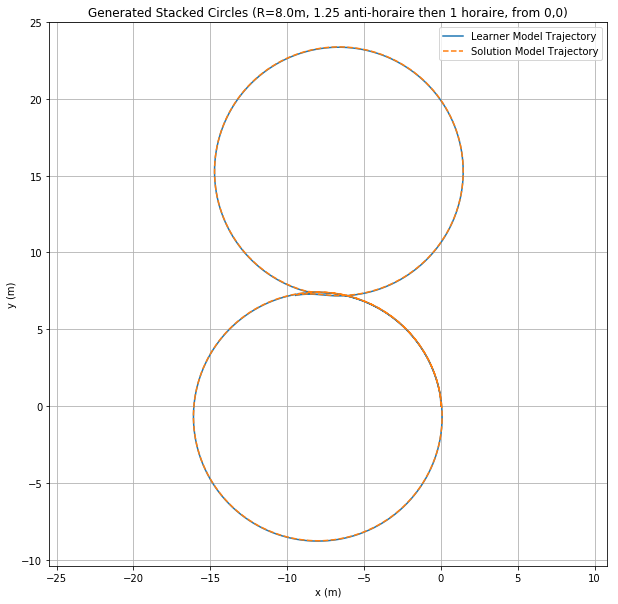

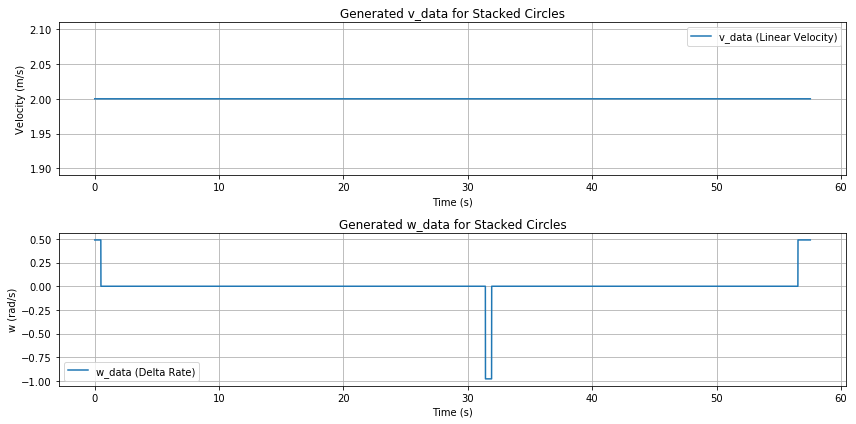

R_cercle: 8.0 m
v_const: 2.0 m/s
time_segment1_duration (1.25 tours): 31.42 s
time_segment2_duration (1 tour): 25.13 s
time_end total: 57.55 s
delta_magn: 14.04 degrees (0.2450 rad)
w_mag: 0.49 rad/s


In [108]:
import numpy as np
import matplotlib.pyplot as plt

# --- REMARQUE IMPORTANTE ---
# Les classes 'Bicycle' et 'BicycleSolution' (avec leurs méthodes __init__, reset, et step_e/step_RK4)
# DOIVENT ÊTRE DÉFINIES ET ACCESSIBLES AVANT D'EXÉCUTER CE SCRIPT.
# Je vais utiliser 'model.step_e()' pour Bicycle et 'solution_model.step_RK4()' pour BicycleSolution
# selon votre dernier code. Vérifiez que c'est correct.
# --- FIN REMARQUE IMPORTANTE ---

# Créer les instances de vos modèles
model = Bicycle()
solution_model = BicycleSolution()

sample_time = 0.01

# --- Paramètres des Cercles ---
R_cercle = 8.0 # Rayon des cercles : 8.0 mètres
v_const = 2.0 # Vitesse linéaire constante (m/s)

# Magnitude de l'angle de braquage pour faire un cercle de rayon R_cercle
delta_magn = np.arctan(model.L / R_cercle)

# Taux de rampe pour atteindre l'angle de braquage
w_rise_time = 0.5 # Temps pour atteindre delta_magn (ex: 0.5s)
w_mag = delta_magn / w_rise_time # Magnitude du taux de changement de delta
w_mag = np.clip(w_mag, -model.w_max, model.w_max) # Clamper par rapport à w_max


# --- Définition des temps de segments ---
# Segment 1: 1 tour et 1 quart (1.25 tours) anti-horaire
time_segment1_duration = 1.25 * (2 * np.pi * R_cercle) / v_const

# Segment 2: 1 tour complet
time_segment2_duration = (2 * np.pi * R_cercle) / v_const

time_end = time_segment1_duration + time_segment2_duration + 1.0 # Petite marge à la fin

# Initialisation des DEUX modèles: commence à (0,0), qui est le bas du premier cercle
model.reset()
model.xc = 0.0
model.yc = 0.0
model.theta = np.pi / 2 # Regarde vers le Nord (pour monter depuis le bas du cercle)
model.delta = 0.0 # Angle de braquage initial à zéro

solution_model.reset()
solution_model.xc = 0.0
solution_model.yc = 0.0
solution_model.theta = np.pi / 2
solution_model.delta = 0.0

t_data = np.arange(0, time_end, sample_time)

# Tableaux pour stocker les données de position pour les deux modèles
x_model_data = np.zeros_like(t_data)
y_model_data = np.zeros_like(t_data)
x_solution_data = np.zeros_like(t_data)
y_solution_data = np.zeros_like(t_data)

v_data = np.full_like(t_data, v_const) # Vitesse linéaire constante
w_data = np.zeros_like(t_data)

# Logique de contrôle
for i, t in enumerate(t_data):
    # --- Segment 1: 1.25 tours anti-horaire ---
    if t < w_rise_time:
        # Phase 1.1: Rampe de delta vers +delta_magn (virage à gauche, sens anti-horaire)
        w_data[i] = w_mag
    elif t < time_segment1_duration:
        # Phase 1.2: Maintien de delta à +delta_magn
        w_data[i] = 0
    
    # --- Segment 2: 1 tour complet horaire (enchaîné) ---
    # La transition se fait au début du deuxième segment.
    # On passe de +delta_magn (fin du 1er segment) à -delta_magn (début du 2nd segment).
    # Cela nécessite une rampe de 2 * w_mag.
    elif t < time_segment1_duration + w_rise_time:
        # Phase 2.1: Rampe de delta de +delta_magn vers -delta_magn (transition vers virage droit)
        w_data[i] = -2 * w_mag # Changement de 2*delta_magn pour inverser le braquage
    elif t < time_segment1_duration + time_segment2_duration:
        # Phase 2.2: Maintien de delta à -delta_magn pour le cercle horaire
        w_data[i] = 0
    else:
        # Phase 2.3: Rampe de delta vers 0 (pour finir droit à la fin de la trajectoire)
        # S'assurer que le delta est ramené à zéro à la fin de la simulation.
        w_data[i] = w_mag # Rampe de -delta_magn vers 0

# Simulation des DEUX modèles dans la même boucle
for i in range(t_data.shape[0]):
    # Enregistrer la position actuelle du 'model'
    x_model_data[i] = model.xc
    y_model_data[i] = model.yc
    
    # Exécuter l'étape de simulation pour le 'model'
    model.step_e(v_data[i], w_data[i]) 

    # Enregistrer la position actuelle du 'solution_model'
    x_solution_data[i] = solution_model.xc
    y_solution_data[i] = solution_model.yc
    
    # Exécuter l'étape de simulation pour le 'solution_model'
    solution_model.step(v_data[i], w_data[i])

# Plot des trajectoires des deux modèles
plt.figure(figsize=(10, 10)) # Ajuster la taille pour les deux cercles
plt.axis('equal')
plt.plot(x_model_data, y_model_data, label='Learner Model Trajectory')
plt.plot(x_solution_data, y_solution_data, label='Solution Model Trajectory', linestyle='--')
plt.title(f"Generated Stacked Circles (R={R_cercle}m, 1.25 anti-horaire then 1 horaire, from 0,0)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid(True)
plt.legend()
plt.show()

# Plot des v_data et w_data générés
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_data, v_data, label='v_data (Linear Velocity)')
plt.title('Generated v_data for Stacked Circles')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_data, w_data, label='w_data (Delta Rate)')
plt.title('Generated w_data for Stacked Circles')
plt.xlabel('Time (s)')
plt.ylabel('w (rad/s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print(f"R_cercle: {R_cercle} m")
print(f"v_const: {v_const} m/s")
print(f"time_segment1_duration (1.25 tours): {time_segment1_duration:.2f} s")
print(f"time_segment2_duration (1 tour): {time_segment2_duration:.2f} s")
print(f"time_end total: {time_end:.2f} s")
print(f"delta_magn: {np.degrees(delta_magn):.2f} degrees ({delta_magn:.4f} rad)")
print(f"w_mag: {w_mag:.2f} rad/s")




We will now run your speed and angular rate inputs through our bicycle model solution. This is to ensure that your trajectory is correct along with your model. The cell below will display the path generated by our model along with some waypoints on a desired figure 8. Surrounding these waypoints are error tolerance circles with radius 1.5m, your solution will pass the grader if the trajectory generated stays within 80% of these circles.

Assessment passed! Your trajectory meets 100.0% of the waypoints.


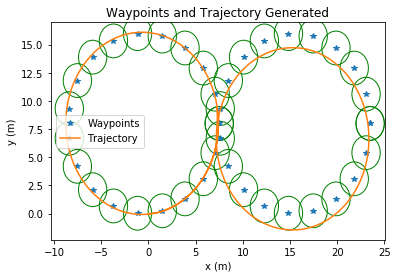

In [109]:
grade_bicycle(t_data,v_data,w_data)

The cell below will save the time and vehicle inputs as text file named $\textit{figure8.txt}$. To locate the file, change the end of your web directory to $\textit{/notebooks/Course_1_Module_4/figure8.txt}$

Once you are there, you can download the file and submit to the Coursera grader to complete this assessment.

In [110]:
data = np.vstack([t_data, v_data, w_data]).T
np.savetxt('figure8.txt', data, delimiter=', ')

Congratulations! You have now completed the assessment! Feel free to test the bicycle model with different inputs in the cell below, and see what trajectories they form. For example, try moving in an equilateral triangle. You'll find that it's rather difficult to generate desired trajectories by pre-setting the inputs. The next module on vehicle control will show you an easier and more accurate method. See you there!

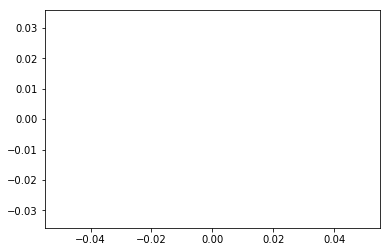

In [111]:
sample_time = 0.01
time_end = 30
model.reset()

t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
y_data = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)
w_data = np.zeros_like(t_data)

# ==================================
#  Test various inputs here
# ==================================
for i in range(t_data.shape[0]):

    model.step_RK4(v_data[i], w_data[i])
    
plt.axis('equal')
plt.plot(x_data, y_data)
plt.show()